In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import XLMTokenizer, XLMForSequenceClassification
from transformers import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import time
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Veri setini yükleyin
df = pd.read_csv("0206_veriler.csv")

# Metin verilerini ve etiketleri ayırın
texts = df["Twitler"].values
labels = df["Durum"].values

# Etiketleri tensörlere dönüştürün
labels = torch.tensor(labels)

In [3]:
# Train ve test veri setlerini ayırın
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [4]:
# XLM tokenizer'ı oluşturun
tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-17-1280')


In [5]:
# Metinleri XLM için uygun girişlere dönüştürün
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Girişleri tensörlere dönüştürün
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])

# DataLoader oluşturun
batch_size = 16
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
train_sampler = RandomSampler(train_dataset)
test_sampler = SequentialSampler(test_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [6]:
# XLM modelini yükleyin
model = XLMForSequenceClassification.from_pretrained('xlm-mlm-17-1280', num_labels=2)

Some weights of the model checkpoint at xlm-mlm-17-1280 were not used when initializing XLMForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing XLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMForSequenceClassification were not initialized from the model checkpoint at xlm-mlm-17-1280 and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'transformer.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infer

In [7]:
# GPU kullanılabilirse kullanın
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer ve scheduler ayarlarını yapın
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# Eğitim döngüsü
epochs = 10
train_losses = []
test_losses = []
train_times = []
test_times = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()
    
    for batch in train_dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=batch_inputs,
                        attention_mask=batch_masks,
                        labels=batch_labels)
        
        loss = outputs.loss
        total_train_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    train_time = time.time() - start_time
    train_times.append(train_time)
    
    print("Epoch:", epoch+1)
    print("Training Loss:", avg_train_loss)
    print("Train Time:", train_time)
    
    model.eval()
    total_test_loss = 0
    predictions = []
    start_time = time.time()
    
    for batch in test_dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=batch_inputs,
                            attention_mask=batch_masks,
                            labels=batch_labels)
        
        loss = outputs.loss
        logits = outputs.logits
        
        total_test_loss += loss.item()
        
        softmax = torch.nn.Softmax(dim=1)
        probabilities = softmax(logits)
        preds = torch.argmax(probabilities, dim=1)
        predictions.extend(preds.tolist())
    
    avg_test_loss = total_test_loss / len(test_dataloader)
    test_losses.append(avg_test_loss)
    test_time = time.time() - start_time
    test_times.append(test_time)
    
    accuracy = accuracy_score(test_labels.tolist(), predictions)
    precision = precision_score(test_labels.tolist(), predictions)
    recall = recall_score(test_labels.tolist(), predictions)
    f1 = f1_score(test_labels.tolist(), predictions)
    
    print("Test Loss:", avg_test_loss)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Test Time:", test_time)
    print()



Epoch: 1
Training Loss: 1.1246421173214913
Train Time: 318.3773262500763
Test Loss: 0.8337103247642517
Accuracy: 0.44871794871794873
Precision: 0.6153846153846154
Recall: 0.32653061224489793
F1-Score: 0.42666666666666664
Test Time: 10.620870113372803

Epoch: 2
Training Loss: 0.7882063180208206
Train Time: 323.361123085022
Test Loss: 0.7096780598163605
Accuracy: 0.6025641025641025
Precision: 0.6323529411764706
Recall: 0.8775510204081632
F1-Score: 0.7350427350427351
Test Time: 8.804025888442993

Epoch: 3
Training Loss: 0.8511663109064103
Train Time: 312.26625204086304
Test Loss: 0.6850219368934631
Accuracy: 0.6282051282051282
Precision: 0.6282051282051282
Recall: 1.0
F1-Score: 0.7716535433070866
Test Time: 9.198062896728516

Epoch: 4
Training Loss: 0.8222656607627868
Train Time: 316.23243618011475
Test Loss: 0.6784459710121155
Accuracy: 0.6153846153846154
Precision: 0.6417910447761194
Recall: 0.8775510204081632
F1-Score: 0.7413793103448276
Test Time: 8.082165002822876

Epoch: 5
Training 

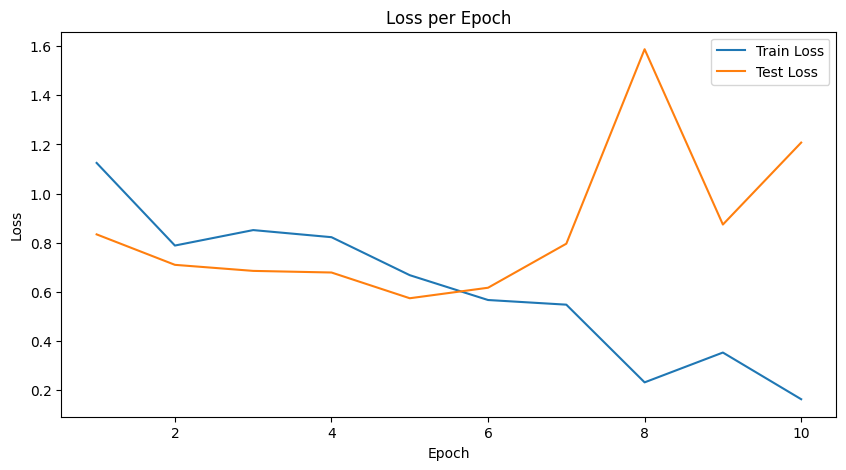

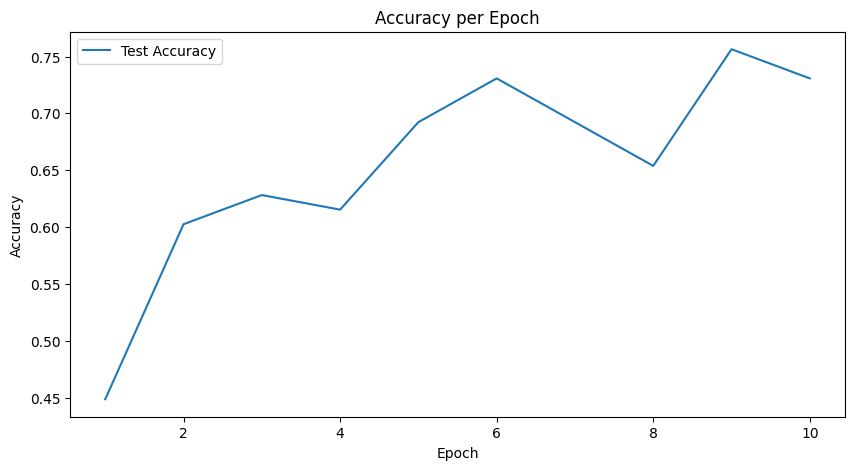

In [25]:
# Loss-epoch grafiği
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

accuracy_values=[0.44871794871794873,0.6025641025641025,0.6282051282051282,0.6153846153846154,0.6923076923076923,0.7307692307692307,0.6923076923076923,0.6538461538461539,0.7564102564102564,0.7307692307692307]
# Accuracy-epoch grafiği
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()
